In [2]:
%load_ext rpy2.ipython
%R library(ggplot2);library(dplyr);library(magrittr);library(parody); library(reshape)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


<StrVector - Python:0x10a3ce7a0 / R:0x107649df8>
[str, str, str, ..., str, str, str]

In [2]:
import subprocess

def run_trna_scan(input_file, output):
    if os.path.exists(output):
        os.remove(output)
    args=["tRNAscan-SE", "-o", output, "-G", "-D","-N", input_file]
    subprocess.call(args)
    print("tRNA scan of "+input_file+" is done!")
    
from Bio import SeqIO
import subprocess
import os

## now extract all CDS from genbank file:
def gbk_to_cds_fasta(gbk, output):
    handle=SeqIO.parse(gbk,"genbank")
    output=open(output,"w")
    count=0
    for g in handle:
        for feature in g.features:
            if feature.type=="CDS":
                count=count+1
                if "locus_tag" in feature.qualifiers.keys():
                    feature_name=feature.qualifiers["locus_tag"][0]
                elif "gene" in feature.qualifiers.keys(): 
                    feature_name=feature.qualifiers["gene"][0]
                else:
                    feature_name=feature.qualifiers["product"][0]
                feature_seq=feature.extract(g.seq)
                output.write(">"+str(feature_name)+"\n"+str(feature_seq)+"\n")
    print(str(count)+ " CDS sequences extracted from "+gbk)
    output.close()

def gbk_to_fasta(gbk, output):
    SeqIO.convert(gbk,"gb",output,"fasta")
    
def run_codonM(fasta, output):
    subprocess.call(["perl","./scripts/codonR/codonM",fasta,output])
    
def run_codonW(fasta, outfile):
    options=["-enc","-gc","-gc3s","-L_aa","-nomenu","-nowarn"]
    subprocess.call(["./scripts/codonR/codonW/codonw",fasta, outfile]+options)
    

def extract_cds_annotations(gbfile, outputfile):
    out=open(outputfile,"w")
    out.write("title\tproduct\n")
    handle=SeqIO.parse(gbfile,"genbank")
    count=0
    for g in handle:
        for feature in g.features:
            if feature.type=="CDS":
                count=count+1
                if "locus_tag" in feature.qualifiers.keys():
                    feature_name=feature.qualifiers["locus_tag"][0]
                elif "gene" in feature.qualifiers.keys(): 
                    feature_name=feature.qualifiers["gene"][0]
                else:
                    feature_name=feature.qualifiers["product"][0]

                if "product" in feature.qualifiers.keys():
                    feature_product=feature.qualifiers["product"][0]
                else:
                    feature_product="unannotated"
                out.write(feature_name+"\t"+feature_product+"\n")

    out.close()
    print(str(count)+" annotated features in "+gbfile)

In [3]:
%%R

format_codon_m<-function(codonm, codonw){
    codon_w<-read.table(codonw, header=TRUE, sep="\t", na.strings="*****")
    codonm<-codonm%>%scan%>%matrix(ncol=61, byrow=T)
    rownames(codonm)<-codon_w$title
    ccn<-read.table("./scripts/codonR/codonm_colnames.txt", sep="\t")
    colnames(codonm)<-ccn$V2
    return(codonm)
}

gptr<-function(codonlist, gene){
        anti<-read.table("anti_codon_table.txt", header=TRUE, sep="\t")%>%filter(exact==1)
        codon_prop=vector()    
        codons_tested=vector()
        gene$codon<-rownames(gene)
        colnames(gene)[1]<-"count"
        merge(anti, gene, by="codon")->gene
        gene%>%filter(exact==1)%>%group_by(aa)%>%summarise(aa_count=sum(count))->aa_sum

        for (codon in codonlist){
            if (codon %in% gene$codon) {
            codons_tested=c(codons_tested, codon)
            a=gene$aa[which(codon==gene$codon)]
            n=gene$count[which(codon==gene$codon)]     #the number of exact match codons in the gene
            total=aa_sum$aa_count[which(a==aa_sum$aa)] #the total number of codons for the specific amino acid
            codon_prop=c(codon_prop, n/total)
        }}
        return(cbind.data.frame(codons_tested, codon_prop))
      }

Gptr<-function(codonlist, codonm){
    anti<-read.table("anti_codon_table.txt", header=TRUE, sep="\t")%>%filter(exact==1)
    genome_codon_prop=vector()
    codons_tested=vector()
    genome<-data.frame(colSums(codonm))
    genome$codon<-rownames(genome)
    colnames(genome)[1]<-"count"

    merge(anti, genome, by="codon")->genome

    genome%>%group_by(aa)%>%summarise(aa_count=sum(count))->genome_aa_sum

    for (codon in codonlist){
        if (codon %in% genome$codon){
        codons_tested=c(codons_tested, codon)
        a=genome$aa[which(codon==genome$codon)]
        n=genome$count[which(codon==genome$codon)]     #the number of exact match codons in the gene
        total=genome_aa_sum$aa_count[which(a==genome_aa_sum$aa)] #the total number of codons for the specific amino acid
        genome_codon_prop=c(genome_codon_prop, n/total)
        }}
        output<-cbind.data.frame(codons_tested, genome_codon_prop)
        return(output)
        }


In [23]:
for phage in phages:
    fasta="/Users/jmb/Desktop/ViralFate/PhageGenomeAssembly/final_fastas_bp/"+phage+"final.fasta\n"
    out_name="./data/nahant_trna_count/"+phage+"trnas.txt"
    run_trna_scan(fasta, out_name)

tRNA scan of /Users/jmb/Desktop/ViralFate/PhageGenomeAssembly/final_fastas_bp/1.003.O.final.fasta
 is done!
tRNA scan of /Users/jmb/Desktop/ViralFate/PhageGenomeAssembly/final_fastas_bp/1.004.O.final.fasta
 is done!
tRNA scan of /Users/jmb/Desktop/ViralFate/PhageGenomeAssembly/final_fastas_bp/1.005.O.final.fasta
 is done!
tRNA scan of /Users/jmb/Desktop/ViralFate/PhageGenomeAssembly/final_fastas_bp/1.007.O.final.fasta
 is done!
tRNA scan of /Users/jmb/Desktop/ViralFate/PhageGenomeAssembly/final_fastas_bp/1.008.O.final.fasta
 is done!
tRNA scan of /Users/jmb/Desktop/ViralFate/PhageGenomeAssembly/final_fastas_bp/1.009.O.final.fasta
 is done!
tRNA scan of /Users/jmb/Desktop/ViralFate/PhageGenomeAssembly/final_fastas_bp/1.011.O.final.fasta
 is done!
tRNA scan of /Users/jmb/Desktop/ViralFate/PhageGenomeAssembly/final_fastas_bp/1.012.O.final.fasta
 is done!
tRNA scan of /Users/jmb/Desktop/ViralFate/PhageGenomeAssembly/final_fastas_bp/1.013.O.final.fasta
 is done!
tRNA scan of /Users/jmb/Desk

In [4]:
import glob
import os

names=glob.glob("./data/nahant_tRNA_count/*")

phages=[]
count=0

for name in names:
    phages.append(name.split("/")[-1].split("t")[0])
    count+=1
  
print(count)

tRNA_phages=[]

for phage in phages:
    if os.path.getsize("./data/nahant_trna_count/"+phage+"trnas.txt")>0:
        #print("phage "+phage+" has tRNAs")
        tRNA_phages.append(phage)
    #else:
     #   print("phage "+phage+" does not have tRNAs")

print("there are a total of "+str(len(phages))+" phages but only "+str(len(tRNA_phages))+" have tRNAs")

287
there are a total of 287 phages but only 65 have tRNAs


In [5]:
adj=open("/Users/jmb/Desktop/ViralFate/ImportantInfo/KK_adjtbl_info.txt").readlines()

phage_hr_dict={}

for p in phages:
    hostlist=[]
    for line in adj[1:]:
        phage=line.split("\t")[0]
        host=line.split("\t")[3]
        if p==phage:
            hostlist.append(host)
    phage_hr_dict[p]=hostlist


In [6]:
hosts=[]

trna_info="phage\tnum_hosts\tnum_trnas\ttrna\n"

for p in tRNA_phages:
    num_hosts=len(phage_hr_dict[p])
    for i in phage_hr_dict[p]:
        if i not in hosts:
            hosts.append(i)
    num_trnas=len(open("./data/nahant_trna_count/"+p+"trnas.txt").readlines())
    if num_trnas>0:
        trna="1"
    else:
        trna="0"
    trna_info+=p+"\t"+str(num_hosts)+"\t"+str(num_trnas)+"\t"+trna+"\n"
print(trna_info.split("\n")[1:10])

['1.007.O.\t1\t7\t1', '1.012.O.\t6\t4\t1', '1.013.O.\t2\t5\t1', '1.022.O.\t1\t4\t1', '1.023.O.\t1\t5\t1', '1.024.O.\t1\t4\t1', '1.025.O.\t6\t4\t1', '1.026.O.\t6\t4\t1', '1.031.O.\t1\t5\t1']


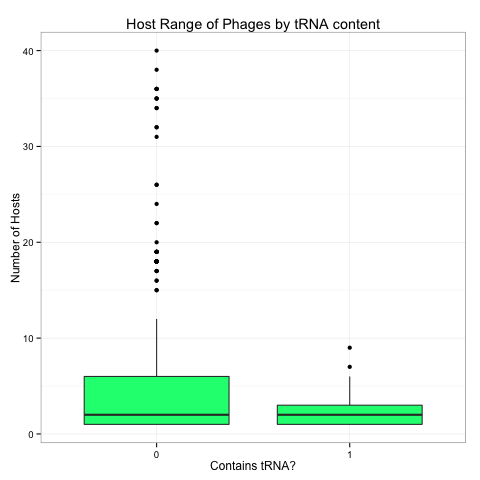

In [19]:
%%R -i trna_info
ti<-textConnection(trna_info)%>%read.table(header=TRUE, sep="\t")

ti%>%ggplot(aes(as.factor(trna), num_hosts))+geom_boxplot(fill="springgreen")+theme_bw()->tiplot
tiplot<-tiplot+labs(x="Contains tRNA?", y="Number of Hosts", title="Host Range of Phages by tRNA content")
plot(tiplot)

###Clearly having tRNAs is not a prequisit to having a broad host range for the Nahant Vibriophages

In [20]:
%%R
host_x<-read.table("/Users/jmb/Desktop/ViralFate/HostPhylogeny/PairwiseGenomeIdentity/Nahant_HRX_PIDs.txt", sep="\t")
host_x$one<-gsub("_",".",host_x$V1)
host_x$two<-gsub("_",".",host_x$V2)
head(host_x)
host_dist<-host_x[,c(4,5,3)]
head(host_dist)

             one            two       V3
1 10N.222.46.E12  10N.286.49.B9 97.98060
2  10N.222.52.A7 10N.261.52.F12 85.73275
3 10N.286.46.A12  10N.286.54.F4 85.80467
4  10N.286.54.C4 10N.286.55.E12 77.83640
5 10N.222.54.F11  10N.261.55.E8 81.98377
6 10N.286.45.F12         1F.111 82.93564


In [21]:
%%R -i phages


adjtbl<-read.table("/Users/jmb/Desktop/ViralFate/OldFolders/Phage-Host/NetworkAdjacencyList.txt", sep="\t", header=TRUE)

host_distances<-vector()
num_hosts<-vector()

for (i in phages) {
    hostlist<-adjtbl$HRX.HOST.ID[which(adjtbl$Phage.ID==i)]
    number<-length(hostlist)
    num_hosts<-c(num_hosts, number)
    if (number>1){
    #host_rel<-with(host_dist, host_dist[one %in% hostlist, ])%>%with(.,.[two %in% hostlist,])%>%with(., mean(V3))
    host_rel<-with(host_dist, host_dist[one %in% hostlist, ])%>%with(.,.[two %in% hostlist,])%>%with(., min(V3))
    #print(paste(phage, host_rel, sep=" "))
    if (is.na(host_rel)){host_rel<-100}
    host_distances<-c(host_distances, host_rel)
    }
    else {
        host_rel=100
        host_distances<-c(host_distances, 100)
    }
    #print(paste(i, host_rel, sep="  "))
}
cbind.data.frame(phages, host_distances)->host_distances

ti$hostdiversity<-host_distances$host_distances[match(ti$phage, host_distances$phages)]
    

       phage num_hosts num_trnas trna hostdiversity
8   1.012.O.         6         4    1      75.30964
71  1.085.O.         2         5    1      76.55752
106 1.121.O.         2         6    1      74.85252
226 1.247.A.         2         4    1      75.68420
227 1.247.B.         2         4    1      75.68420


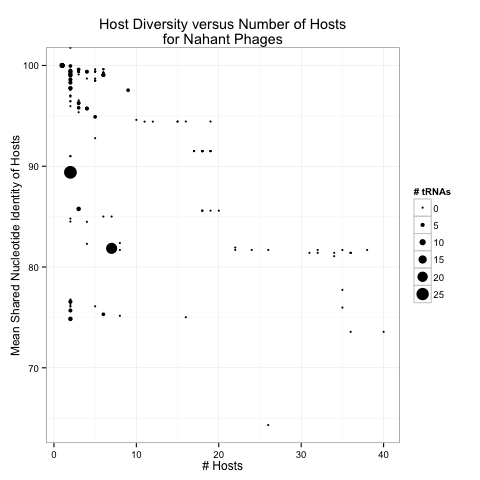

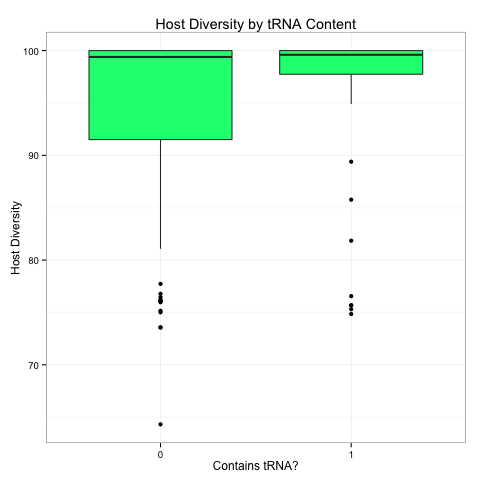

In [28]:
%%R
colors<-c("red","blue")
ggplot(ti, aes(num_hosts, hostdiversity))+geom_point(aes(size=num_trnas))->graph
graph<-graph+labs(title="Host Diversity versus Number of Hosts\nfor Nahant Phages", x="# Hosts",
                 y="Mean Shared Nucleotide Identity of Hosts", size="# tRNAs")+theme_bw()
plot(graph)

print(ti[which(ti$hostdiversity<80 & ti$num_trnas>0),])

ggplot(ti, aes(as.factor(trna), hostdiversity))+geom_boxplot(fill="springgreen")+theme_bw()->graph2
graph2<-graph2+labs(title="Host Diversity by tRNA Content", x="Contains tRNA?", y="Host Diversity")
plot(graph2)

2.275.O is the phage I'd like to work with to see genes from different hosts targeted by its tRNAs.

##Looking at hosts of a specific phage:

In [7]:
poi="2.275.O."
hoi=phage_hr_dict[poi]

In [116]:
import subprocess

poi="2.275.O."
#hosts are:
args2=["mkdir","nvib"]
subprocess.call(args2)

for host in phage_hr_dict[poi]:
    #args=["scp","jbrown@eofe4.mit.edu:/nobackup1/jbrown/vibrio_genomes/"+host+"_contigs_prod.gbk","./"]

    args3=["mv",host+"_contigs_prod.gbk","./nvib"]
    subprocess.call(args3)
hoi=phage_hr_dict[poi]


for h in hoi:
    gbk_to_cds_fasta("./nvib/"+h+"_contigs_prod.gbk", "./nvib/"+h+".cds.fasta")
    run_codonM("./nvib/"+h+".cds.fasta", "./nvib/"+h+".m")
    run_codonW("./nvib/"+h+".cds.fasta", "./nvib/"+h+".w")
    extract_cds_annotations("./nvib/"+h+"_contigs_prod.gbk","./nvib/"+h+"cds.annotations.txt")

6080 CDS sequences extracted from ./nvib/10N.286.45.B12_contigs_prod.gbk
6080 annotated features in ./nvib/10N.286.45.B12_contigs_prod.gbk
4677 CDS sequences extracted from ./nvib/10N.286.45.B8_contigs_prod.gbk
4677 annotated features in ./nvib/10N.286.45.B8_contigs_prod.gbk
4653 CDS sequences extracted from ./nvib/10N.286.45.C3_contigs_prod.gbk
4653 annotated features in ./nvib/10N.286.45.C3_contigs_prod.gbk
2541 CDS sequences extracted from ./nvib/10N.286.45.E12_contigs_prod.gbk
2541 annotated features in ./nvib/10N.286.45.E12_contigs_prod.gbk
4306 CDS sequences extracted from ./nvib/10N.286.49.A5_contigs_prod.gbk
4306 annotated features in ./nvib/10N.286.49.A5_contigs_prod.gbk
4346 CDS sequences extracted from ./nvib/10N.286.52.F6_contigs_prod.gbk
4346 annotated features in ./nvib/10N.286.52.F6_contigs_prod.gbk
4422 CDS sequences extracted from ./nvib/10N.286.54.E11_contigs_prod.gbk
4422 annotated features in ./nvib/10N.286.54.E11_contigs_prod.gbk


Read 370880 items
Read 285297 items
Read 283833 items
Read 155001 items
Read 262666 items
Read 265106 items
Read 269742 items
[1] "10N.286.45.B12: 25"
     gene_order      title    Nc  GC3s    GC L_aa gene_ptcs
1640       1640  ORF_463_2 54.38 0.311 0.370   63  1.804727
2603       2603  ORF_784_1 58.20 0.511 0.500   92  1.947032
3224       3224  ORF_998_3 61.00 0.396 0.429   49  1.932340
3258       3258 ORF_1014_1 39.07 0.217 0.284  116  1.905910
3965       3965 ORF_1324_1 39.62 0.261 0.348   93  1.792410
4496       4496 ORF_1597_1 51.54 0.403 0.437  135  1.818560
5363       5363 ORF_2103_1 38.03 0.444 0.450   37  1.900492
5426       5426 ORF_2145_1 44.02 0.467 0.453   95  2.454676
5752       5752 ORF_2401_1 42.38 0.345 0.403   62  1.940872
                                                                   product
1640                                                           Unannotated
2603                                                           Unannotated
3224 Ribulose-5-phosphat

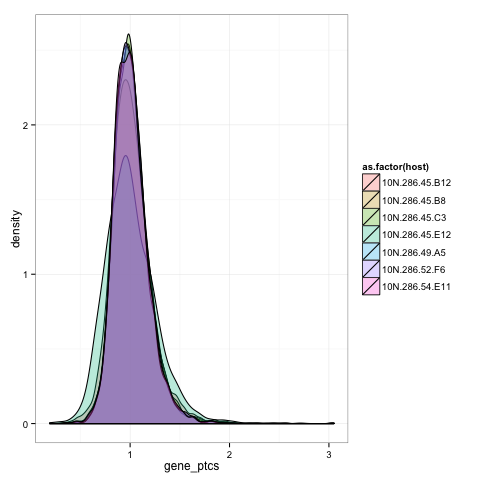

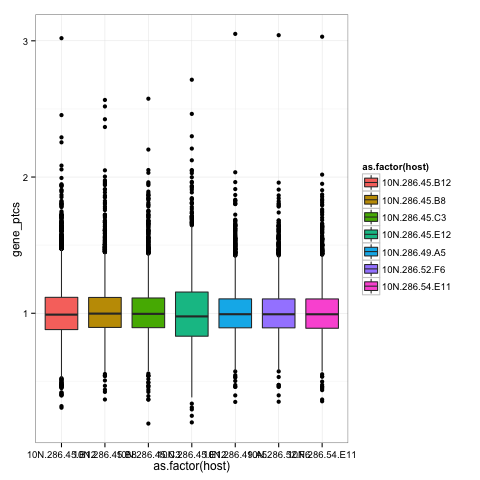

In [8]:
%%R -i poi -i hoi

codonlist<-read.table(paste("./data/nahant_trna_count/", poi, "trnas.txt",sep=""), skip=3, header=FALSE,sep="\t")
codonlist$V6%>%unique->codonlist
codonlist

combo<-data.frame(gene_order=integer(),title=character(),Nc=integer(),GC3s=integer(),GC=integer(),L_aa=integer(),gene_ptcs=integer(),product=character(),host=factor())

for (j in hoi){
    codonm<-format_codon_m(paste("./nvib/",j,".m", sep=""),paste("./nvib/",j,".w", sep=""))
    codonw<-read.table(paste("./nvib/",j,".w", sep=""))
    Genome_rep<-Gptr(codonlist, codonm)
    gene_ptcs<-vector()
    for (i in seq(1:nrow(codonm))){
    Gene_rep<-gptr(codonlist, data.frame(codonm[i,]))
    Together<-merge(Genome_rep, Gene_rep, by="codons_tested")%>%mutate(pig=codon_prop/genome_codon_prop)
    ptcs<-mean(na.omit(Together$pig))
    gene_ptcs<-c(gene_ptcs, ptcs)
}
    host_w<-read.table(paste("./nvib/",j,".w", sep=""), header=TRUE, sep="\t", na.strings="*****")
    host_w$X<-NULL
    cbind.data.frame(host_w, gene_ptcs)->host_w
    gene_order<-seq(1:nrow(host_w))
    host_w<-cbind.data.frame(gene_order, host_w)
    annotations<-read.csv(paste("./nvib/",j,"cds.annotations.txt",sep=""), header=TRUE, sep="\t")
    host_w$title<-gsub(" ","",host_w$title)
    annotations$title<-gsub(" ","",annotations$title)
    host_w$product<-annotations$product[match(host_w$title, annotations$title)]
    host_w$host<-j
    combo<-rbind(host_w, combo)
}



[1] "10N.286.45.B12: 25"
     gene_order      title    Nc  GC3s    GC L_aa gene_ptcs
567         567  ORF_148_4 57.15 0.432 0.474  147  1.852636
587         587  ORF_153_1    NA 0.556 0.417   28  2.291419
1640       1640  ORF_463_2 54.38 0.311 0.370   63  1.804727
2137       2137  ORF_624_1 54.46 0.278 0.368   38  2.055927
2251       2251  ORF_666_4 36.50 0.370 0.356   29  3.019294
2603       2603  ORF_784_1 58.20 0.511 0.500   92  1.947032
3224       3224  ORF_998_3 61.00 0.396 0.429   49  1.932340
3258       3258 ORF_1014_1 39.07 0.217 0.284  116  1.905910
3288       3288 ORF_1031_1 47.58 0.400 0.481   52  1.868665
3524       3524 ORF_1124_2 61.00 0.294 0.365   52  1.890985
3965       3965 ORF_1324_1 39.62 0.261 0.348   93  1.792410
4038       4038 ORF_1356_1 50.14 0.333 0.407   59  1.784784
4496       4496 ORF_1597_1 51.54 0.403 0.437  135  1.818560
4903       4903 ORF_1817_2 50.96 0.361 0.446   77  2.254757
5239       5239 ORF_2019_1 34.18 0.310 0.437   29  2.084087
5362       5362

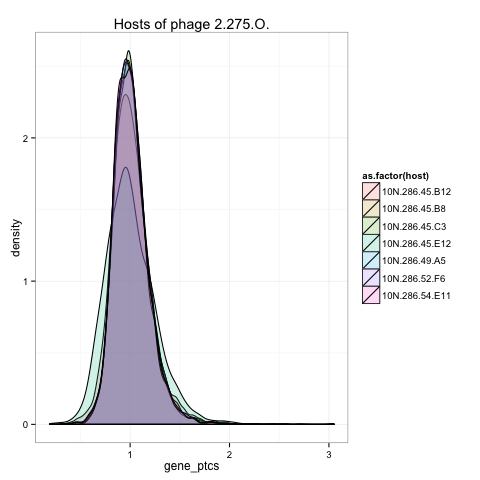

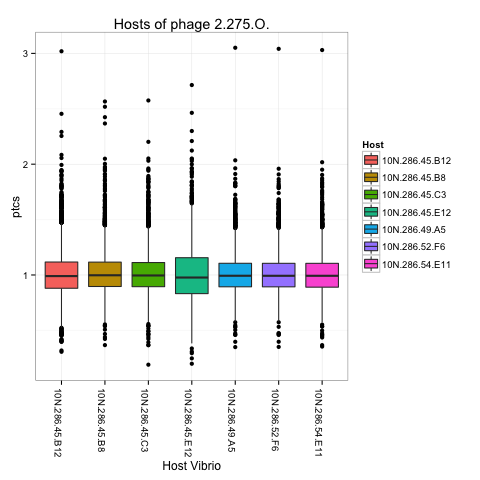

In [22]:
%%R
ggplot(combo, aes(gene_ptcs, fill=as.factor(host)))+geom_density(alpha=0.2)+theme_bw()->g
g<-g+labs(title="Hosts of phage 2.275.O.")
plot(g)

ggplot(combo, aes(as.factor(host), gene_ptcs, fill=as.factor(host)))+geom_boxplot()+theme_bw()->l
l<-l+labs(x="Host Vibrio", y="ptcs",title="Hosts of phage 2.275.O.", fill="Host")+theme(axis.text.x=element_text(angle = -90, hjust = 0))
plot(l)

out<-data.frame(product=factor(), count=integer(), genome=factor())
for (h in hoi){
    combo%>%filter(host==h)->indiv
    outliers<-calout.detect(na.omit(indiv$gene_ptcs), alpha=0.05, method="boxplot")
    print(paste(h, nrow(indiv[outliers$ind,c(1,8)]), sep=": "))
    indiv[outliers$ind,]%>%print
    indiv[outliers$ind,]->io
    io[c(8)]%>%nrow%>%print
    io%>%group_by(product)%>%summarise(count=n())->proteins
    proteins$genome<-h
    out<-rbind.data.frame(out, proteins)
    }
write.table(out, file="./nvib/2.275.O._host_ptcs_outliers.txt", quote=FALSE, sep="\t", row.names=FALSE)

[1] "10N.286.45.B12"
[1] 24
     gene_order      title    Nc  GC3s    GC L_aa gene_ptcs
567         567  ORF_148_4 57.15 0.432 0.474  147  1.852636
1640       1640  ORF_463_2 54.38 0.311 0.370   63  1.804727
2137       2137  ORF_624_1 54.46 0.278 0.368   38  2.055927
2251       2251  ORF_666_4 36.50 0.370 0.356   29  3.019294
2603       2603  ORF_784_1 58.20 0.511 0.500   92  1.947032
3224       3224  ORF_998_3 61.00 0.396 0.429   49  1.932340
3258       3258 ORF_1014_1 39.07 0.217 0.284  116  1.905910
3288       3288 ORF_1031_1 47.58 0.400 0.481   52  1.868665
3524       3524 ORF_1124_2 61.00 0.294 0.365   52  1.890985
3965       3965 ORF_1324_1 39.62 0.261 0.348   93  1.792410
4038       4038 ORF_1356_1 50.14 0.333 0.407   59  1.784784
4496       4496 ORF_1597_1 51.54 0.403 0.437  135  1.818560
4903       4903 ORF_1817_2 50.96 0.361 0.446   77  2.254757
5239       5239 ORF_2019_1 34.18 0.310 0.437   29  2.084087
5362       5362 ORF_2102_2 42.11 0.264 0.377   54  1.993182
5363       5

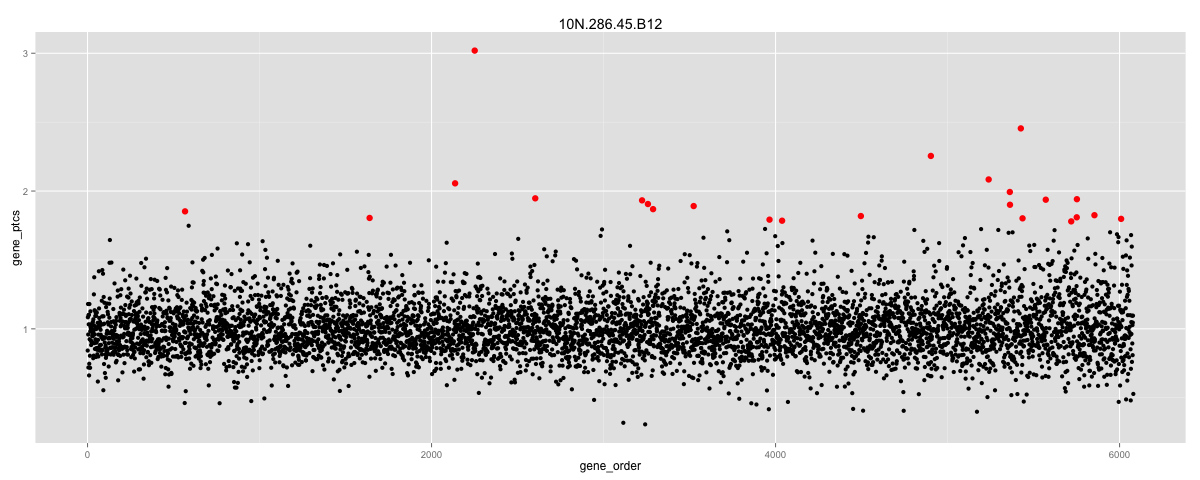

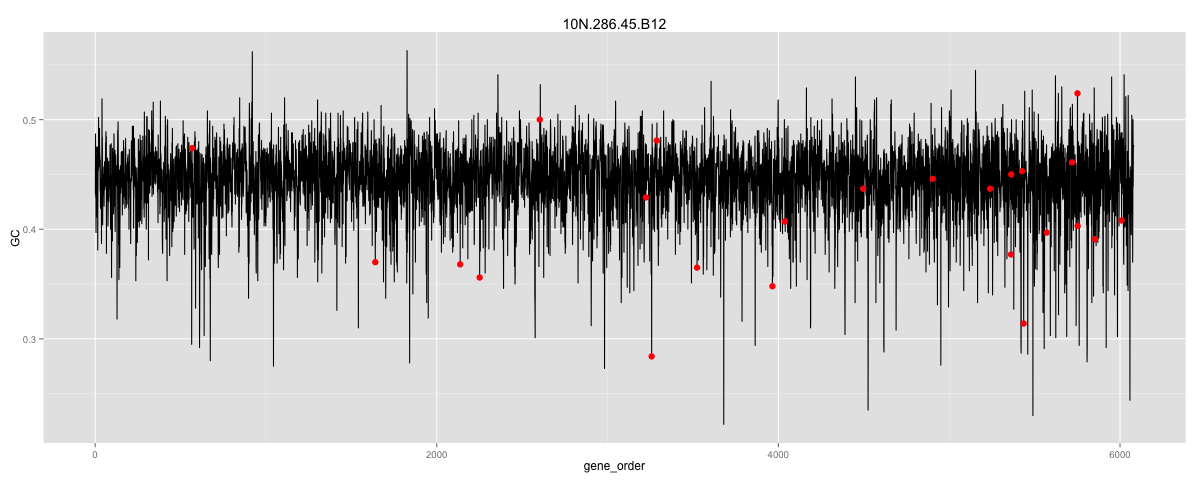

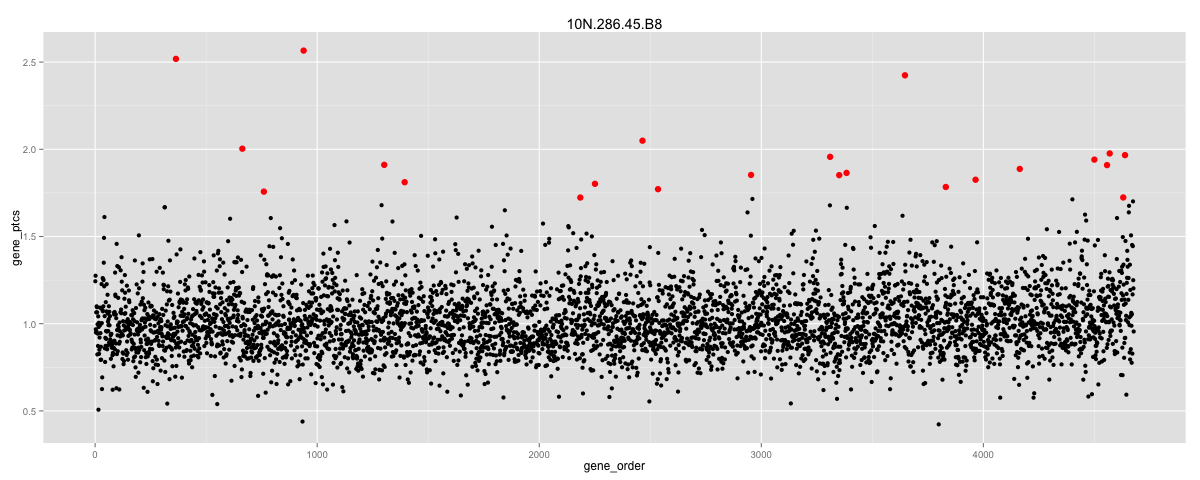

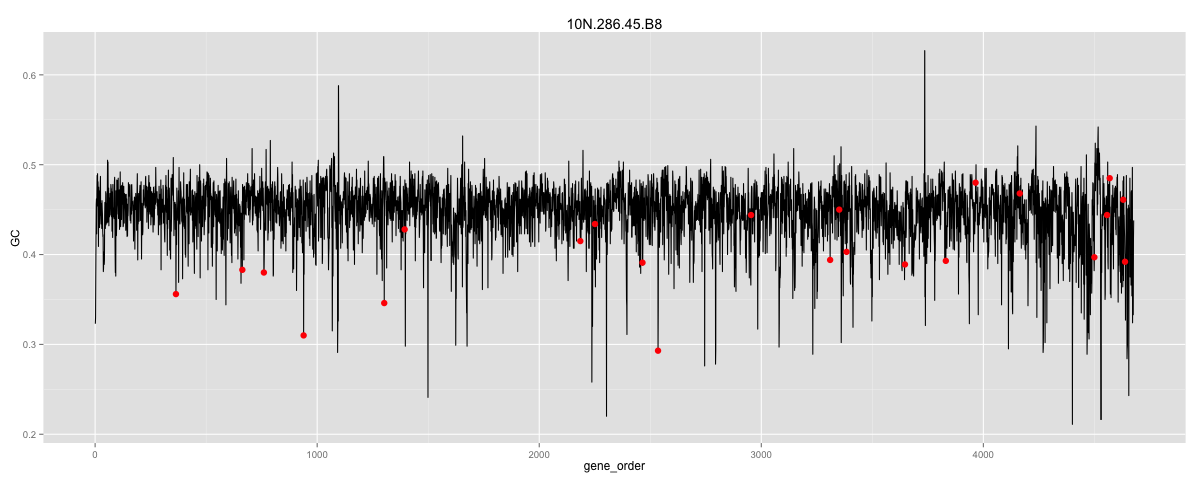

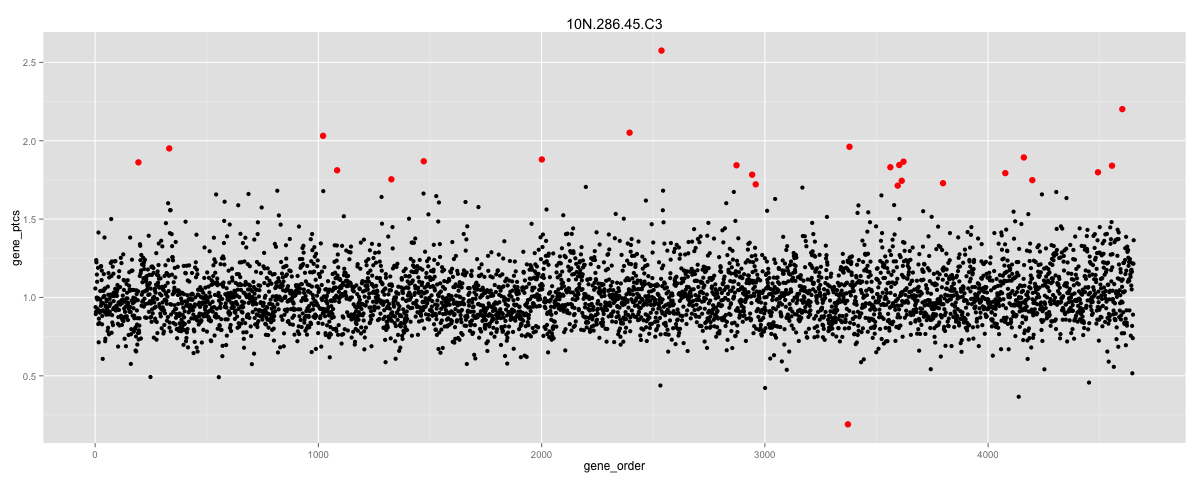

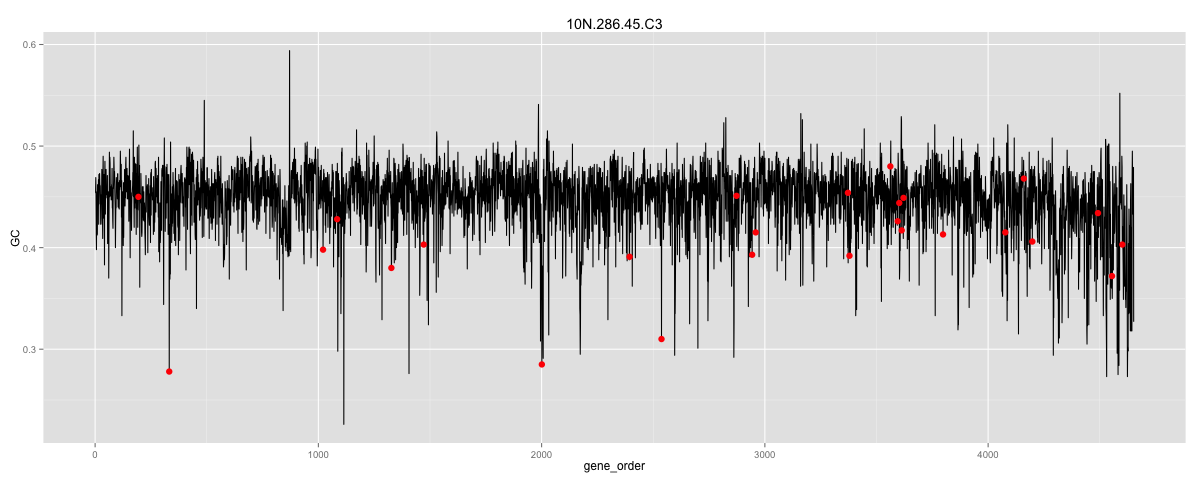

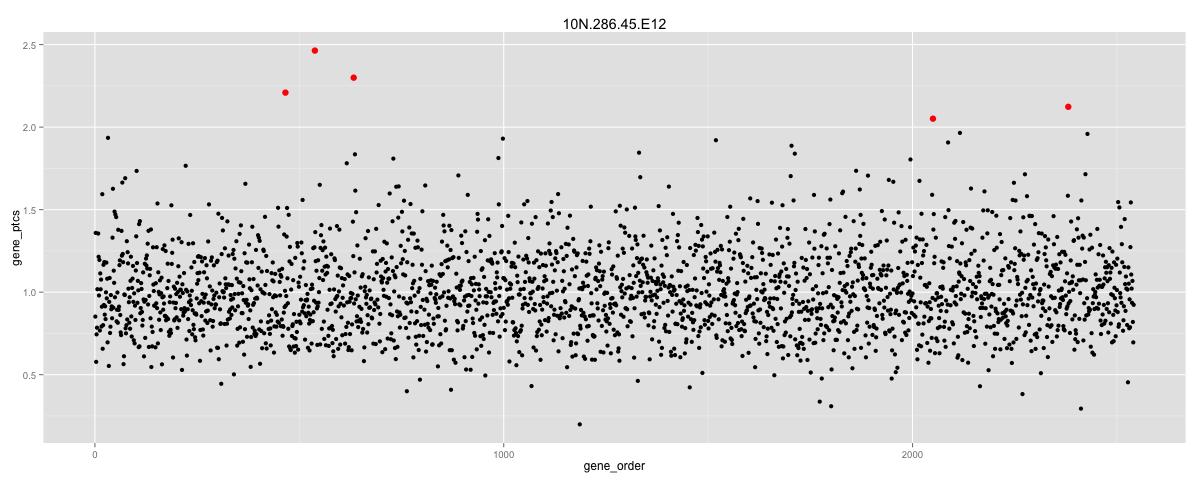

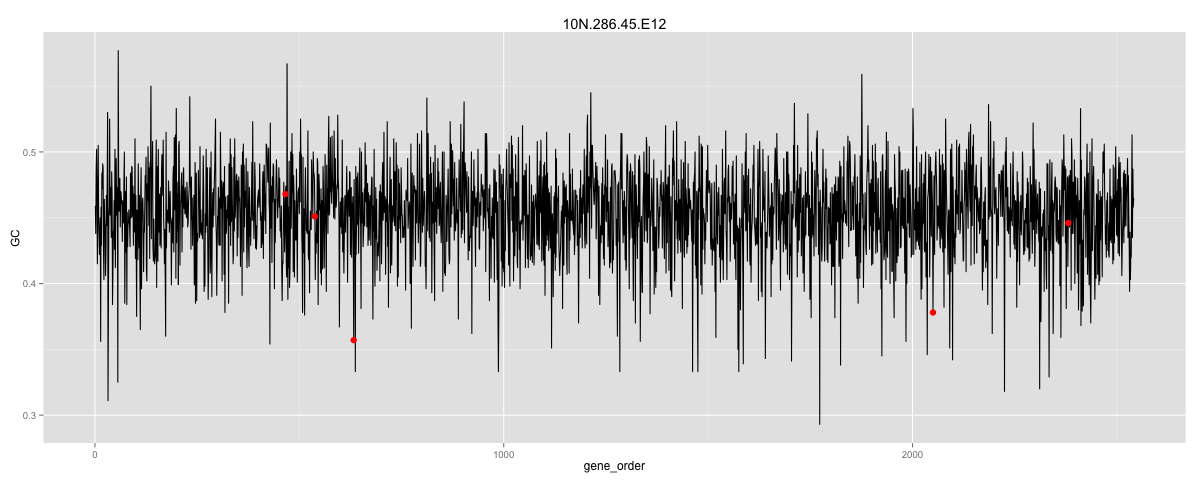

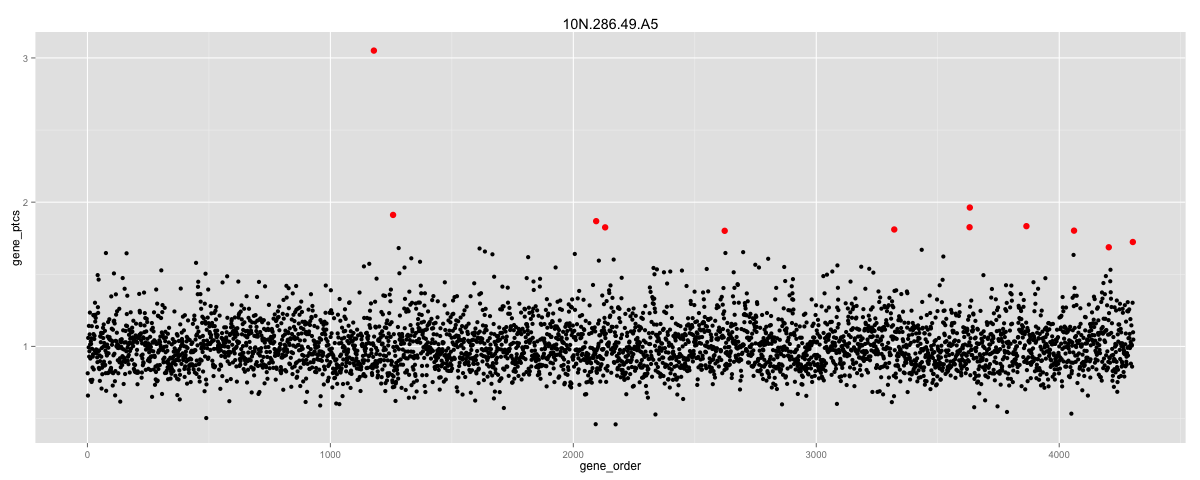

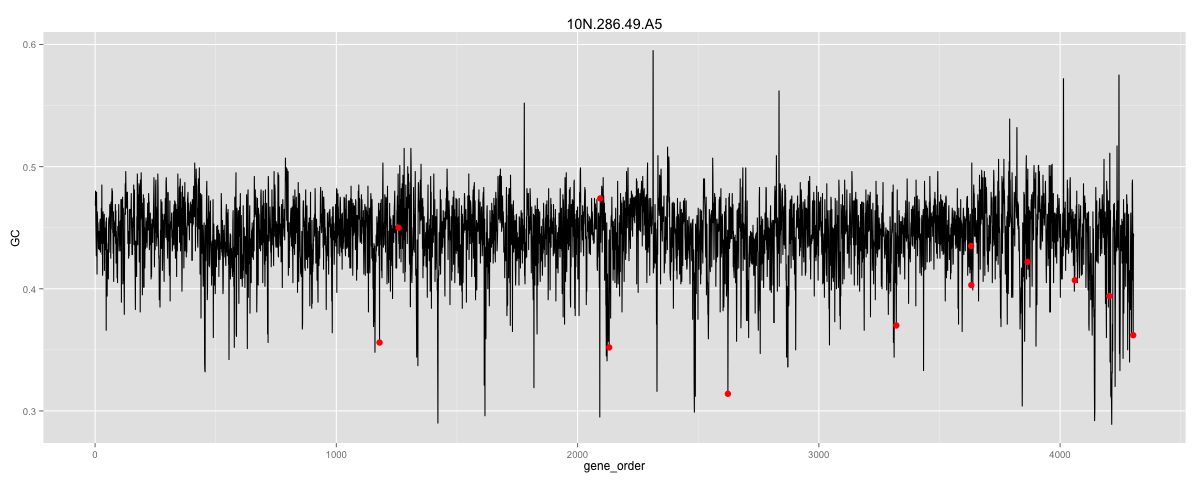

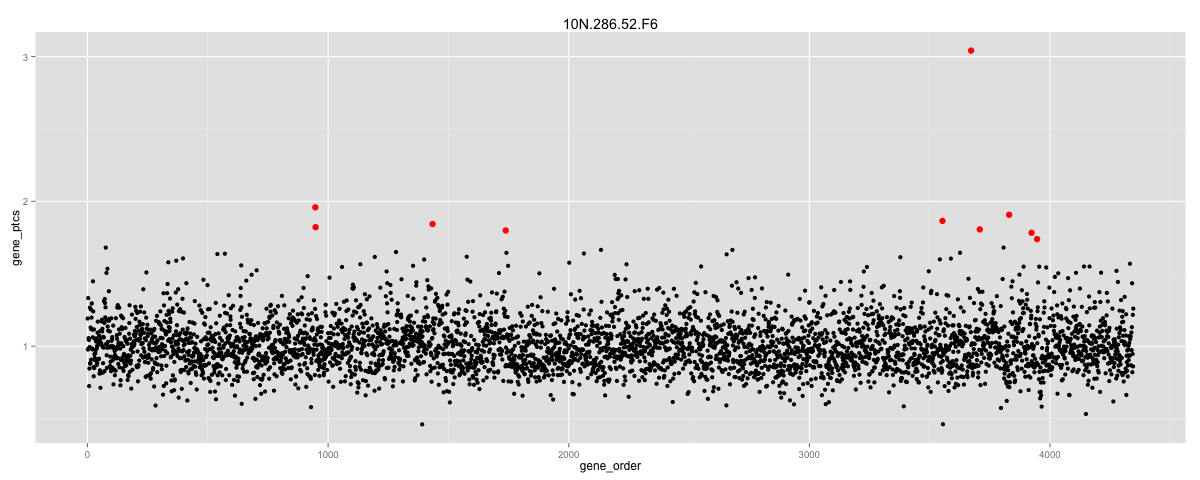

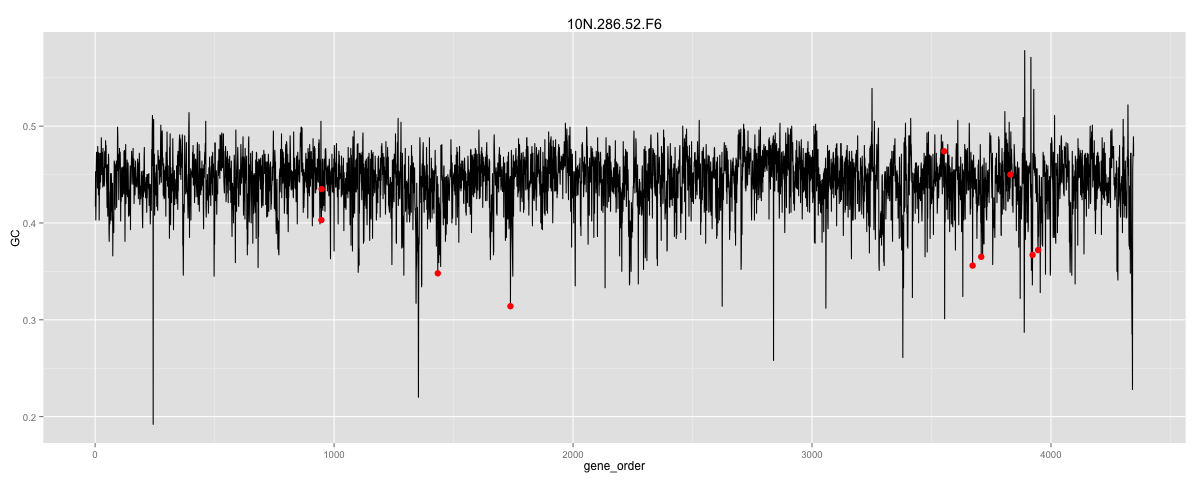

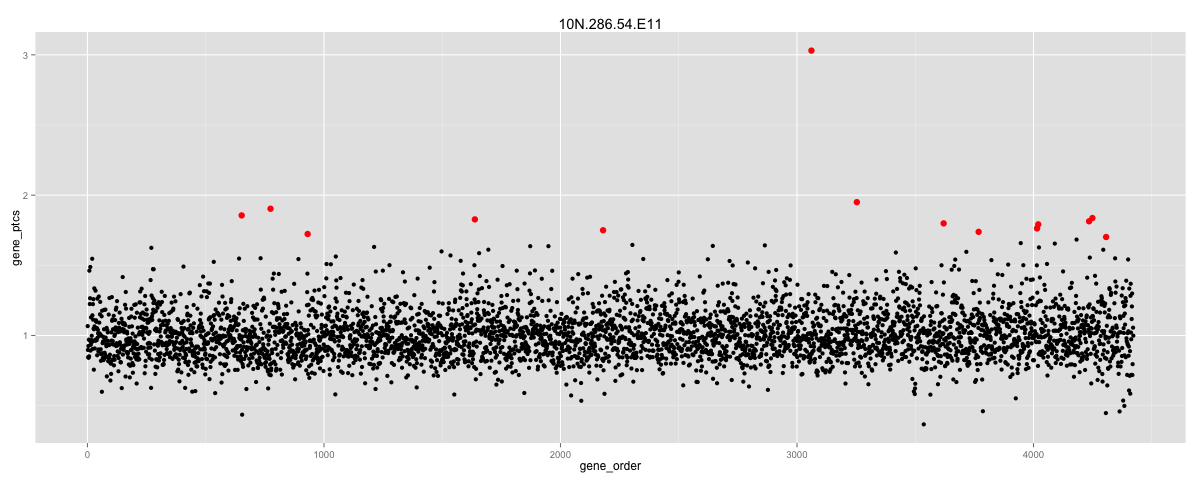

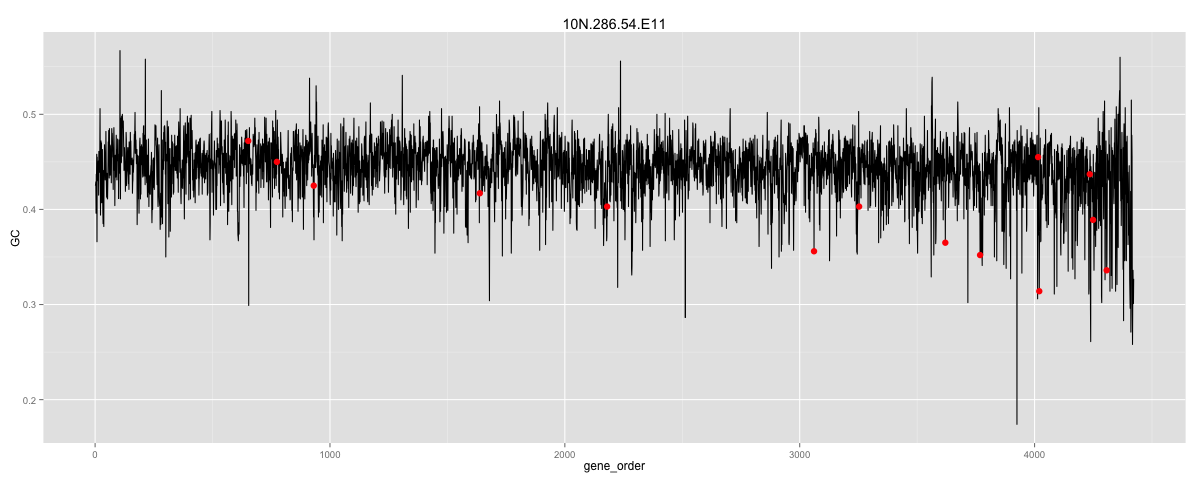

In [15]:
%%R -w 1200
for (h in hoi){
    combo%>%filter(host==h)%>%na.omit->indiv
    outliers<-calout.detect(indiv$gene_ptcs, alpha=0.05, method="boxplot")
    ggplot(NULL, aes(gene_order, gene_ptcs))+geom_point(data=indiv)+labs(title=h)->l
    l+geom_point(data= indiv[outliers$ind,],color="red", cex=3)->o
    plot(o)
    
    ggplot(NULL, aes(gene_order, GC))+geom_line(data=indiv)+labs(title=h)->l
    l+geom_point(data= indiv[outliers$ind,],aes(gene_order, GC),color="red", cex=3)->o
    plot(o)
    
    print(h)
    indiv[outliers$ind,]%>%nrow%>%print
    indiv[outliers$ind,]%>%print
    #indiv[indiv$gene_ptcs>3,]%>%print
#    plot(o)
    #print(indiv[outliers$ind,c(2)])
    }

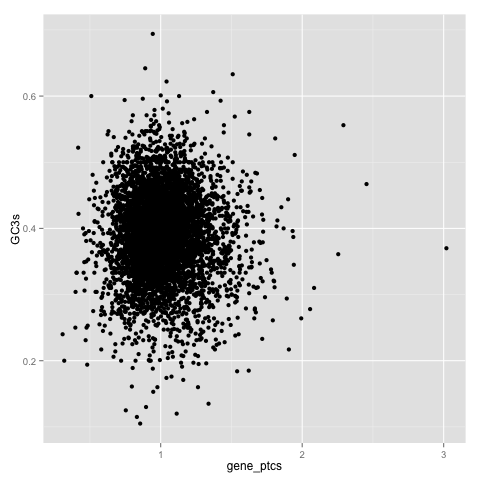

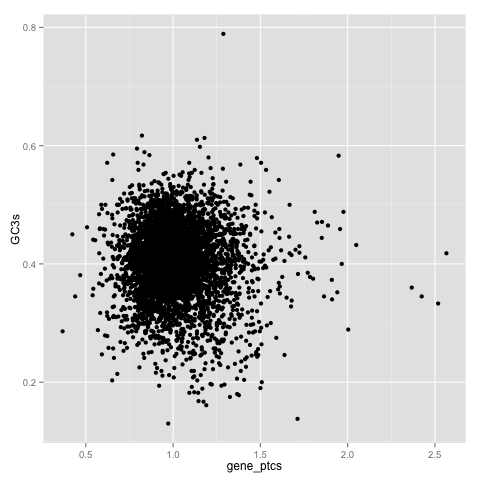

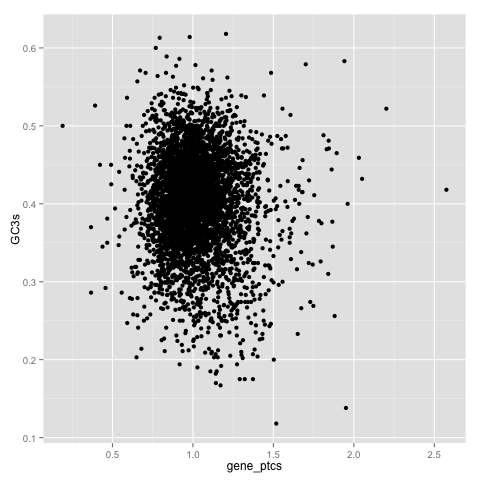

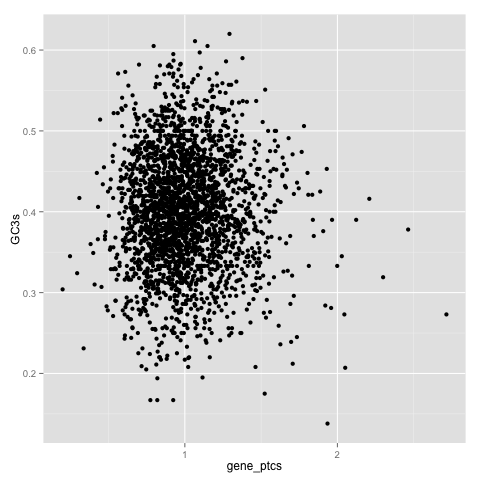

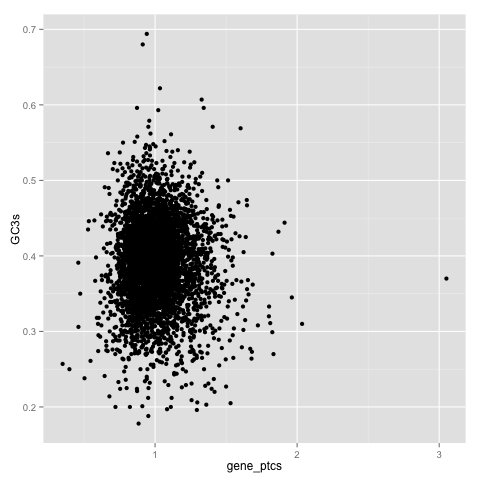

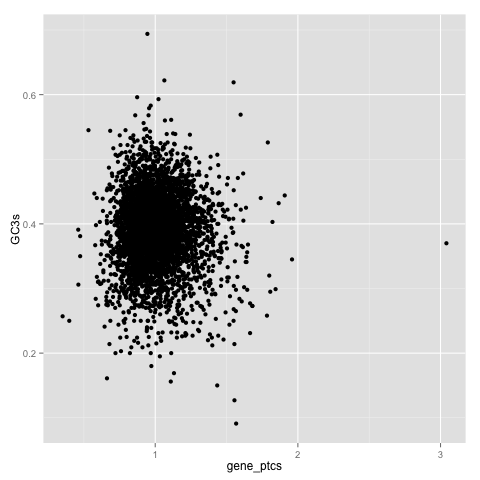

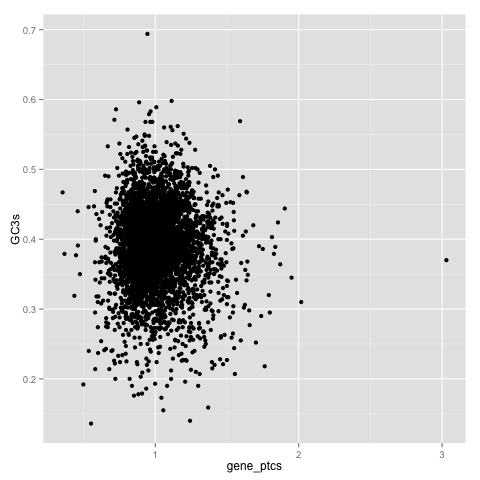

In [16]:
%%R
for (h in hoi){
    filter(combo, host==h)->indiv
    ggplot(indiv, aes(gene_ptcs, GC3s))+geom_point()->out
    plot(out)
    }

In [10]:
poi="1.255.O."
hoi=phage_hr_dict[poi]

In [128]:
import subprocess

#hosts are:
#args2=["mkdir","nvib"]
#subprocess.call(args2)
#import host genomes from server:
for host in phage_hr_dict[poi]:
    args=["scp","jbrown@eofe4.mit.edu:/nobackup1/jbrown/vibrio_genomes/"+host+"_contigs_prod.gbk","./nvib/"]
    subprocess.call(args)
#prepare files for R input:
for h in hoi:
    gbk_to_cds_fasta("./nvib/"+h+"_contigs_prod.gbk", "./nvib/"+h+".cds.fasta")
    run_codonM("./nvib/"+h+".cds.fasta", "./nvib/"+h+".m")
    run_codonW("./nvib/"+h+".cds.fasta", "./nvib/"+h+".w")
    extract_cds_annotations("./nvib/"+h+"_contigs_prod.gbk","./nvib/"+h+"cds.annotations.txt")

4879 CDS sequences extracted from ./nvib/10N.261.52.F2_contigs_prod.gbk
4879 annotated features in ./nvib/10N.261.52.F2_contigs_prod.gbk
11590 CDS sequences extracted from ./nvib/10N.286.45.F1_contigs_prod.gbk
11590 annotated features in ./nvib/10N.286.45.F1_contigs_prod.gbk
10718 CDS sequences extracted from ./nvib/10N.286.46.B11_contigs_prod.gbk
10718 annotated features in ./nvib/10N.286.46.B11_contigs_prod.gbk


In [153]:
for h in hoi:
    gbk_to_fasta("./nvib/"+h+"_contigs_prod.gbk", "./nvib/"+h+".fasta")
    run_trna_scan("./nvib/"+h+".fasta","./nvib/"+h+".trna")

tRNA scan of ./nvib/10N.261.52.F2.fasta is done!
tRNA scan of ./nvib/10N.286.45.F1.fasta is done!
tRNA scan of ./nvib/10N.286.46.B11.fasta is done!


In [169]:
for h in hoi:
    subprocess.call(["mv","./nvib"+h+".trna", "./nvib/"+h+".trna"])

Read 297619 items
Read 706990 items
Read 653798 items
[1] "10N.261.52.F2: 70"
     gene_order      title    Nc  GC3s    GC L_aa gene_ptcs
82           82   ORF_3_19 49.71 0.354 0.431   99  5.910048
239         239  ORF_10_18 51.92 0.437 0.452  140  4.421216
264         264  ORF_10_43 58.85 0.461 0.456  174  4.827182
446         446  ORF_16_44 54.09 0.432 0.447   94  6.018306
665         665  ORF_17_11 55.41 0.410 0.398  103  4.015249
705         705  ORF_17_51 37.36 0.250 0.373   50  4.935728
1164       1164  ORF_26_14 51.11 0.241 0.333   61 11.161989
1399       1399  ORF_33_14 51.32 0.246 0.350  138  5.025463
1633       1633  ORF_41_25 51.83 0.274 0.328  387  5.003029
2181       2181  ORF_54_15 53.03 0.423 0.421  118  5.360821
2680       2680  ORF_71_25 58.27 0.503 0.456  179  4.097539
2816       2816  ORF_75_42 55.65 0.379 0.440  178  4.319973
2873       2873  ORF_75_99 50.25 0.362 0.413  505  4.397335
2917       2917  ORF_81_10 54.49 0.390 0.417  164  4.935728
3121       3121  ORF_8

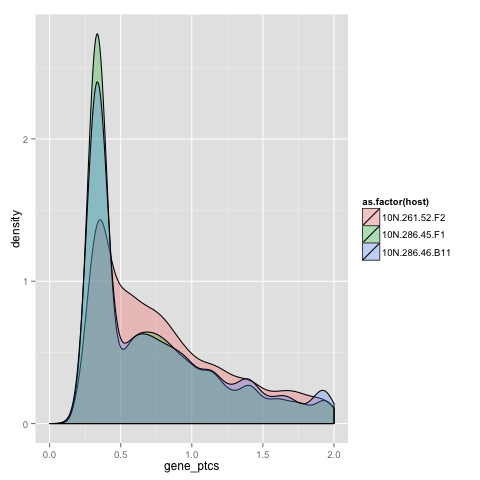

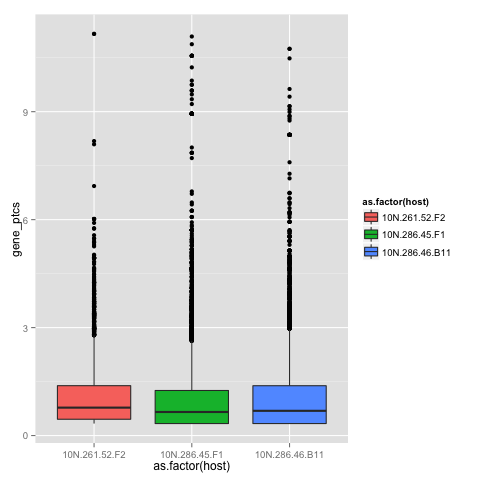

In [11]:
%%R -i poi -i hoi

codonlist<-read.table(paste("./data/nahant_trna_count/", poi, "trnas.txt",sep=""), skip=3, header=FALSE,sep="\t")
codonlist$V6%>%unique->codonlist
codonlist

combo<-data.frame(gene_order=integer(),title=character(),Nc=integer(),GC3s=integer(),GC=integer(),L_aa=integer(),gene_ptcs=integer(),product=character(),host=factor())

for (j in hoi){
    codonm<-format_codon_m(paste("./nvib/",j,".m", sep=""),paste("./nvib/",j,".w", sep=""))
    codonw<-read.table(paste("./nvib/",j,".w", sep=""))
    Genome_rep<-Gptr(codonlist, codonm)
    gene_ptcs<-vector()
    for (i in seq(1:nrow(codonm))){
    Gene_rep<-gptr(codonlist, data.frame(codonm[i,]))
    Together<-merge(Genome_rep, Gene_rep, by="codons_tested")%>%mutate(pig=codon_prop/genome_codon_prop)
    ptcs<-mean(Together$pig)
    gene_ptcs<-c(gene_ptcs, ptcs)
}
    host_w<-read.table(paste("./nvib/",j,".w", sep=""), header=TRUE, sep="\t", na.strings="*****")
    host_w$X<-NULL
    cbind.data.frame(host_w, gene_ptcs)->host_w
    gene_order<-seq(1:nrow(host_w))
    host_w<-cbind.data.frame(gene_order, host_w)
    annotations<-read.csv(paste("./nvib/",j,"cds.annotations.txt",sep=""), header=TRUE, sep="\t")
    host_w$title<-gsub(" ","",host_w$title)
    annotations$title<-gsub(" ","",annotations$title)
    host_w$product<-annotations$product[match(host_w$title, annotations$title)]
    host_w$host<-j
    combo<-rbind(host_w, combo)
}

ggplot(combo, aes(gene_ptcs, fill=as.factor(host)))+geom_density(alpha=0.3)->g
plot(g+xlim(c(0,2)))

ggplot(combo, aes(as.factor(host), gene_ptcs, fill=as.factor(host)))+geom_boxplot()->l
plot(l)
for (h in hoi){
    combo%>%filter(host==h)->indiv
    outliers<-calout.detect(na.omit(indiv$gene_ptcs), alpha=0.05, method="boxplot")
    print(paste(h, nrow(indiv[outliers$ind,c(1,8)]), sep=": "))
    indiv[!is.na(indiv$gene_ptcs),][outliers$ind,][indiv$gene_ptcs>1,]%>%na.omit%>%print
    }

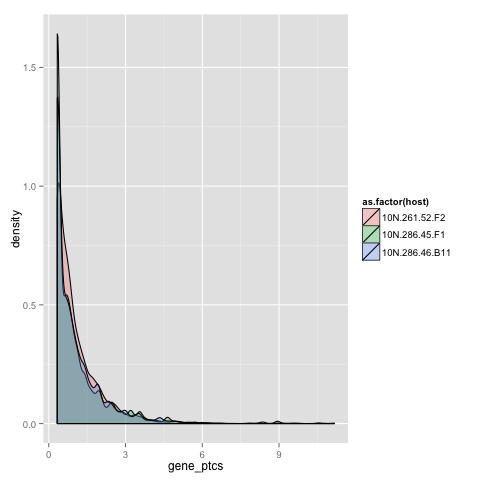

In [142]:
%%R
ggplot(combo, aes(gene_ptcs, fill=as.factor(host)))+geom_density(alpha=0.3)->g
g<-g+geom_vline(data=combo, aes(xintercept=mean(gene_ptcs),  colour=as.factor(host)),linetype="dashed", size=1)
plot(g)

In [178]:
%%R -i poi -i hoi

ptrna<-read.table(paste("./data/nahant_tRNA_count/", poi, "trnas.txt", sep=""), skip=3)%>%group_by(V6)%>%summarise(count=n())
colnames(ptrna)<-c("codon",poi)
ptrna

for (h in hoi){
    trna<-read.table(paste("./nvib/",h,".trna", sep=""), skip=3)%>%group_by(V6)%>%summarise(count=n())%>%data.frame
    colnames(trna)<-c("codon",h)
    ptrna<-merge(ptrna, trna, by="codon", all.x=TRUE, all.y=TRUE)
}
ptrna[is.na(ptrna)]<-0
ptrna



   codon 1.255.O. 10N.261.52.F2 10N.286.45.F1 10N.286.46.B11
1    AGG        1             0             0              0
2    ATG        1             7             2              3
3    GGA        1             3             2              1
4    AAA        0             2             1              1
5    AAC        0             5             0              2
6    ACA        0             4             1              1
7    ACC        0             2             1              1
8    AGA        0             1             1              1
9    AGC        0             2             1              1
10   ATC        0             1             1              1
11   CAA        0             2             1              2
12   CAC        0             2             1              1
13   CCA        0             3             1              1
14   CGG        0             1             1              1
15   CGT        0             2             2              0
16   CTA        0       

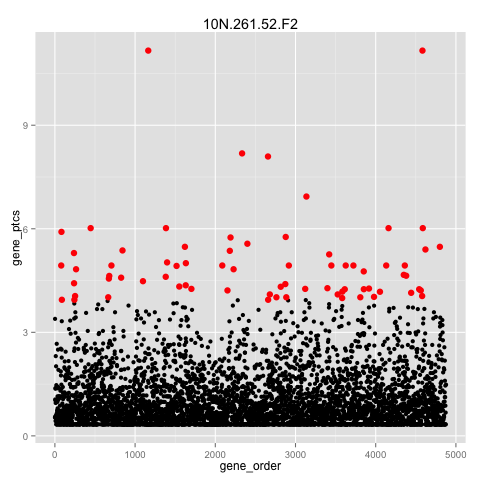

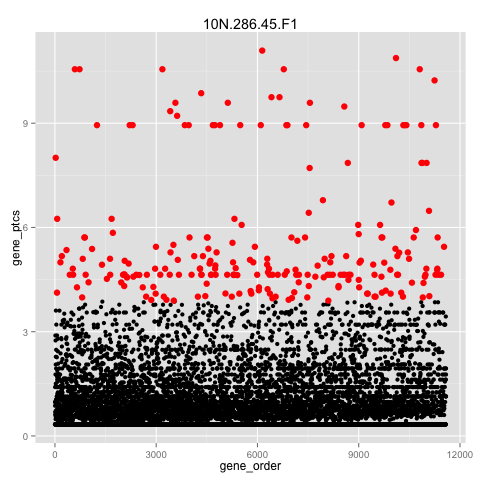

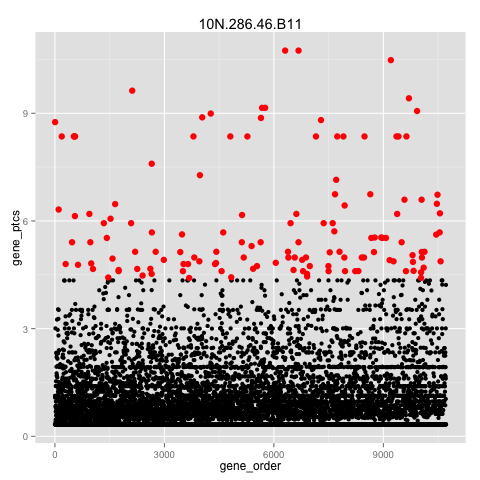

In [25]:
%%R
for (h in hoi){
    combo%>%filter(host==h)%>%na.omit->indiv
    outliers<-calout.detect(indiv$gene_ptcs, alpha=0.05, method="boxplot")
    ggplot(NULL, aes(gene_order, gene_ptcs))+geom_point(data=indiv)+labs(title=h)->l
    l+geom_point(data= indiv[outliers$ind,],color="red", cex=3)->o
    plot(o)
#    plot(o)
    #print(indiv[outliers$ind,c(2)])
    }

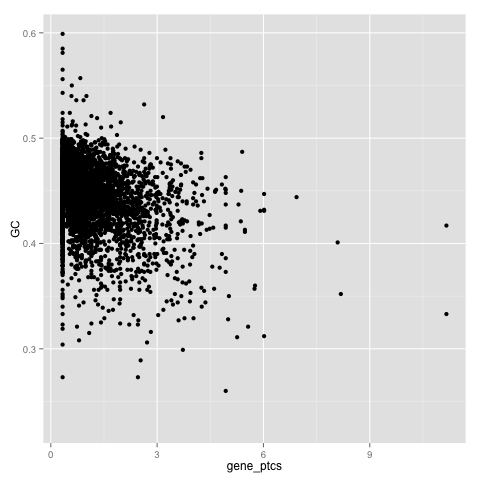

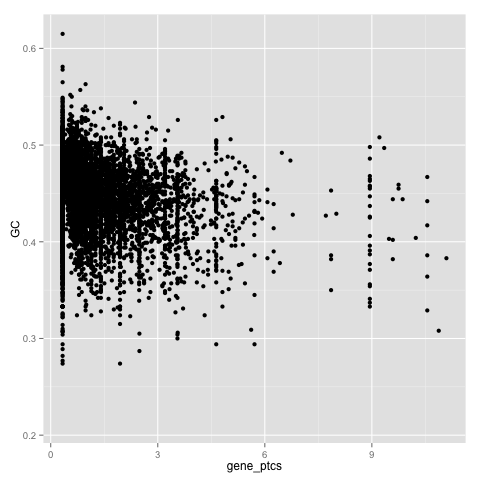

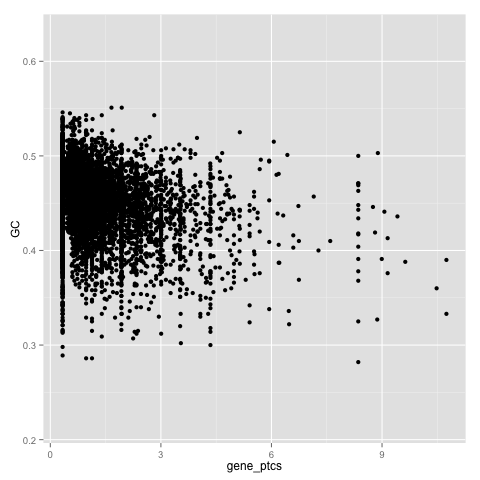

In [12]:
%%R
for (h in hoi){
    filter(combo, host==h)->indiv
    ggplot(indiv, aes(gene_ptcs, GC))+geom_point()->out
    plot(out)
    }

In [13]:
poi="1.012.O."
hoi=phage_hr_dict[poi]

In [125]:

#hosts are:
#args2=["mkdir","nvib"]
#subprocess.call(args2)

for host in phage_hr_dict[poi]:
    args=["scp","jbrown@eofe4.mit.edu:/nobackup1/jbrown/vibrio_genomes/"+host+"_contigs_prod.gbk","./nvib/"]
    
    subprocess.call(args)



for h in hoi:
    if os.path.exists("./nvib/"+h+"_contigs_prod.gbk"):
        #continue
        gbk_to_cds_fasta("./nvib/"+h+"_contigs_prod.gbk", "./nvib/"+h+".cds.fasta")
        run_codonM("./nvib/"+h+".cds.fasta", "./nvib/"+h+".m")
        run_codonW("./nvib/"+h+".cds.fasta", "./nvib/"+h+".w")
        extract_cds_annotations("./nvib/"+h+"_contigs_prod.gbk","./nvib/"+h+"cds.annotations.txt")
    else:
        hoi.remove(h)

In [14]:
%%R -i poi -i hoi

codonlist<-read.table(paste("./data/nahant_trna_count/", poi, "trnas.txt",sep=""), skip=3, header=FALSE,sep="\t")
codonlist$V6%>%unique->codonlist
codonlist

combo<-data.frame(gene_order=integer(),title=character(),Nc=integer(),GC3s=integer(),GC=integer(),L_aa=integer(),gene_ptcs=integer(),product=character(),host=factor())

for (j in hoi){
    codonm<-format_codon_m(paste("./nvib/",j,".m", sep=""),paste("./nvib/",j,".w", sep=""))
    codonw<-read.table(paste("./nvib/",j,".w", sep=""))
    Genome_rep<-Gptr(codonlist, codonm)
    gene_ptcs<-vector()
    for (i in seq(1:nrow(codonm))){
    Gene_rep<-gptr(codonlist, data.frame(codonm[i,]))
    Together<-merge(Genome_rep, Gene_rep, by="codons_tested")%>%mutate(pig=codon_prop/genome_codon_prop)
    ptcs<-mean(Together$pig)
    gene_ptcs<-c(gene_ptcs, ptcs)
}
    host_w<-read.table(paste("./nvib/",j,".w", sep=""), header=TRUE, sep="\t", na.strings="*****")
    host_w$X<-NULL
    cbind.data.frame(host_w, gene_ptcs)->host_w
    gene_order<-seq(1:nrow(host_w))
    host_w<-cbind.data.frame(gene_order, host_w)
    annotations<-read.csv(paste("./nvib/",j,"cds.annotations.txt",sep=""), header=TRUE, sep="\t")
    host_w$title<-gsub(" ","",host_w$title)
    annotations$title<-gsub(" ","",annotations$title)
    host_w$product<-annotations$product[match(host_w$title, annotations$title)]
    host_w$host<-j
    combo<-rbind(host_w, combo)
}

ggplot(combo, aes(gene_ptcs, fill=as.factor(host)))+geom_density(alpha=0.3)->g
plot(g+xlim(c(0,2)))

ggplot(combo, aes(as.factor(host), gene_ptcs, fill=as.factor(host)))+geom_boxplot()->l
plot(l)
for (h in hoi){
    combo%>%filter(host==h)->indiv
    outliers<-calout.detect(na.omit(indiv$gene_ptcs), alpha=0.05, method="boxplot")
    print(paste(h, nrow(indiv[outliers$ind,c(1,8)]), sep=": "))
    indiv[!is.na(indiv$gene_ptcs),][outliers$ind,][indiv$gene_ptcs>1,]%>%na.omit%>%print
    }

Read 221735 items
Error in file(file, "rt") : cannot open the connection
In addition: There were 33 warnings (use warnings() to see them)
Error in file(file, "rt") : cannot open the connection


In [192]:
len(hosts)

for h in hosts:
    if os.path.exists("./nvib/"+h+"_contigs_prod.gbk"):
        print(h+" exists")
    else:
        args=["scp","jbrown@eofe4.mit.edu:/nobackup1/jbrown/vibrio_genomes/"+h+"_contigs_prod.gbk","./nvib/"]
        subprocess.call(args)

10N.261.48.B1 exists
10N.261.48.E3 exists
10N.261.49.F6 exists
10N.261.51.F9 exists
10N.286.51.B9 exists
10N.261.52.F2 exists
10N.286.45.F1 exists
10N.286.46.B11 exists
10N.286.54.E11 exists
10N.286.45.B12 exists
10N.286.45.B8 exists
10N.286.45.C3 exists
10N.286.45.E12 exists
10N.286.49.A5 exists
10N.286.52.F6 exists


In [197]:
for h in hosts:
    if os.path.exists("./nvib/"+h+"_contigs_prod.gbk") and os.path.exists("./nvib/"+h+".w")==False:
        gbk_to_cds_fasta("./nvib/"+h+"_contigs_prod.gbk", "./nvib/"+h+".cds.fasta")
        run_codonM("./nvib/"+h+".cds.fasta", "./nvib/"+h+".m")
        run_codonW("./nvib/"+h+".cds.fasta", "./nvib/"+h+".w")
        extract_cds_annotations("./nvib/"+h+"_contigs_prod.gbk","./nvib/"+h+"cds.annotations.txt")
    
for h in hosts:
    if os.path.exists("./nvib/"+h+".trna"):
        print(h+" exists")
    elif os.path.exists("./nvib/"+h+"_contigs_prod.gbk"):
        gbk_to_fasta("./nvib/"+h+"_contigs_prod.gbk", "./nvib/"+h+".fasta")
        run_trna_scan("./nvib/"+h+".fasta","./nvib/"+h+".trna")
    else:
        print(h+" is not sequenced")

7996 CDS sequences extracted from ./nvib/10N.286.54.F9_contigs_prod.gbk
7996 annotated features in ./nvib/10N.286.54.F9_contigs_prod.gbk
12762 CDS sequences extracted from ./nvib/10N.286.45.A10_contigs_prod.gbk
12762 annotated features in ./nvib/10N.286.45.A10_contigs_prod.gbk
4847 CDS sequences extracted from ./nvib/10N.261.45.F8_contigs_prod.gbk
4847 annotated features in ./nvib/10N.261.45.F8_contigs_prod.gbk
5122 CDS sequences extracted from ./nvib/10N.261.46.F8_contigs_prod.gbk
5122 annotated features in ./nvib/10N.261.46.F8_contigs_prod.gbk
12314 CDS sequences extracted from ./nvib/10N.261.54.F5_contigs_prod.gbk
12314 annotated features in ./nvib/10N.261.54.F5_contigs_prod.gbk
4845 CDS sequences extracted from ./nvib/10N.222.49.B8_contigs_prod.gbk
4845 annotated features in ./nvib/10N.222.49.B8_contigs_prod.gbk
4929 CDS sequences extracted from ./nvib/10N.286.45.C1_contigs_prod.gbk
4929 annotated features in ./nvib/10N.286.45.C1_contigs_prod.gbk
10610 CDS sequences extracted from 

[1] 64
[1] 64
               rowSums.unique_trna_profiles.
10N.261.55.F9                             46
10N.261.48.B1                             75
10N.261.48.E3                             69
10N.261.49.F6                             84
10N.261.51.F9                             73
10N.286.51.B9                             79
10N.286.54.F9                             26
10N.286.45.A10                            32
10N.261.45.F8                             74
10N.261.46.F8                             61
10N.261.54.F5                             29
10N.222.49.B8                             70
10N.286.45.C1                             72
10N.286.52.E3                             31
10N.261.48.B5                             66
10N.286.51.B7                             73
10N.286.52.C2                             84
10N.261.52.F1                             75
10N.261.46.A1                             71
10N.261.45.C6                             89
10N.286.46.C3                            

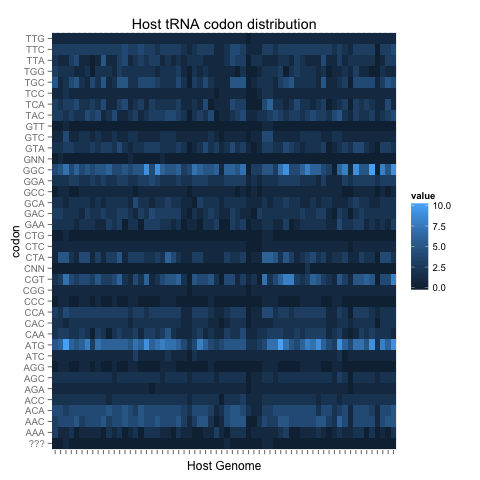

In [8]:
%%R -i hosts
#codon usage in hosts:
trna_file_path="./nvib/"
codons<-read.table("./data/codon_list.txt", header=FALSE)
colnames(codons)[2]<-"V6"

for (phage in hosts){
    trna_file=paste(trna_file_path, phage, ".trna",sep="")
    if (file.info(trna_file)$size>0 & file.exists(trna_file)){
    trna<-read.table(paste(trna_file_path, phage, ".trna",sep=""), skip=3, header=FALSE,sep="\t")
    trna%>%group_by(V6)%>%summarise(count=n())->trna
    colnames(trna)[2]<-phage
    codons<-merge(codons, trna, by="V6", all.x=TRUE, all.y=TRUE)
}}

codons$V1<-NULL
codons[is.na(codons)]<-0
rownames(codons)<-codons$V6
codons$V6<-NULL

members<-t(as.matrix(codons))
unique_trnas<-rownames(unique(members))
unique_trna_profiles<-unique(members)
print(nrow(members))
print(nrow(unique(members)))
print(data.frame(rowSums(unique_trna_profiles)))
t(unique_trna_profiles[,which(colSums(unique_trna_profiles)>0)])%>%.[,order(colSums(.))]->trnas2
trnas2%>%melt%>%ggplot(aes(X2, X1))+geom_tile(aes(fill=value), position="identity")->plt
plt<-plt+labs(title="Host tRNA codon distribution", x="Host Genome", y="codon")
plt<-plt+theme(axis.text.x = element_blank())
plot(plt)

In [9]:
%%R

colorends <- c("white", "red", "white", "green", "white", "blue")
trnas2%>%melt->htmelt
htmelt$cat<-"host"
head(htmelt)

   X1             X2 value  cat
1 AAA 10N.286.45.E12     0 host
2 AAC 10N.286.45.E12     0 host
3 ACA 10N.286.45.E12     2 host
4 ACC 10N.286.45.E12     1 host
5 AGA 10N.286.45.E12     0 host
6 AGC 10N.286.45.E12     0 host


In [10]:
import glob
import os

names=glob.glob("./data/nahant_tRNA_count/*")

phages=[]
count=0

for name in names:
    phages.append(name.split("/")[-1].split("t")[0])
    count+=1
  
print(count)

tRNA_phages=[]

for phage in phages:
    if os.path.getsize("./data/nahant_trna_count/"+phage+"trnas.txt")>0:
        #print("phage "+phage+" has tRNAs")
        tRNA_phages.append(phage)
    #else:
     #   print("phage "+phage+" does not have tRNAs")

print("there are a total of "+str(len(phages))+" phages but only "+str(len(tRNA_phages))+" have tRNAs")

287
there are a total of 287 phages but only 65 have tRNAs


In [11]:
%%R -i tRNA_phages
###Look through tRNA content and select phages with unique tRNA profiles

phagelist<-tRNA_phages
trna_file_path<-"./data/nahant_trna_count/"

codons<-read.table("./data/codon_list.txt", header=FALSE)
colnames(codons)[2]<-"V6"

for (phage in phagelist){
    trna<-read.table(paste(trna_file_path, phage, "trnas.txt",sep=""), skip=3, header=FALSE,sep="\t")
    trna%>%group_by(V6)%>%summarise(count=n())->trna
    colnames(trna)[2]<-phage
    codons<-merge(codons, trna, by="V6", all.x=TRUE, all.y=TRUE)
}


codons$V1<-NULL
codons[is.na(codons)]<-0
rownames(codons)<-codons$V6
codons$V6<-NULL

members<-t(as.matrix(codons))
unique_trnas<-rownames(unique(members))
unique_trna_profiles<-unique(members)
print(nrow(members))
print(nrow(unique(members)))
print(data.frame(rowSums(unique_trna_profiles)))
t(unique_trna_profiles[,which(colSums(unique_trna_profiles)>0)])%>%.[,order(colSums(.))]->trnas2
trnas2%>%melt->ptmelt
ptmelt$cat<-"phage"
head(ptmelt)

[1] 65
[1] 28
         rowSums.unique_trna_profiles.
1.007.O.                             4
1.012.O.                             1
1.013.O.                             2
1.022.O.                             1
1.023.O.                             2
1.024.O.                             1
1.025.O.                             1
1.031.O.                             2
1.032.O.                             1
1.046.O.                             2
1.081.O.                            23
1.085.O.                             2
1.110.O.                             1
1.121.O.                             3
1.122.A.                             2
1.169.O.                             1
1.186.O.                             2
1.187.O.                             2
1.193.O.                             4
1.208.B.                             2
1.214.O.                             1
1.240.O.                             1
1.243.O.                             2
1.244.A.                             3
1.262.O.   

In [13]:
%%R
colorends <- c("white", "red", "white", "blue")

rmelt<-rbind.data.frame(ptmelt, htmelt)
rmelt%>%filter(value>0)%>%mutate(bin=1)->a
rmelt%>%filter(value==0)%>%mutate(bin=0)->b
rbind(a, b)->rmelt
head(rmelt)
rmelt_nz<-filter(rmelt, value>0)

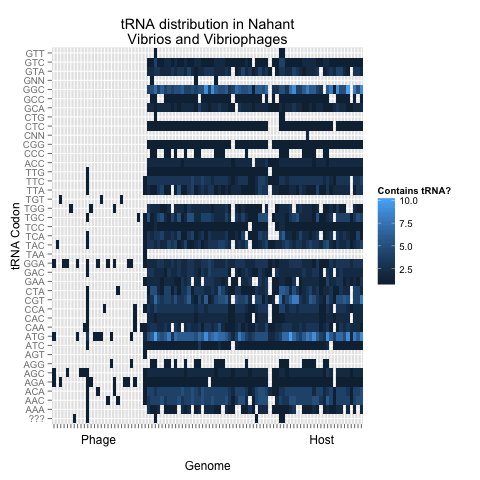

In [16]:
%%R
rmelt$valueoffset <- rmelt$value + 100*(as.numeric(as.factor(rmelt$cat))-1)
scalerange <- range(rmelt$value)
gradientends <- scalerange + rep(c(0,100), each=2)

colors=c("red","black")

ggplot(rmelt_nz, aes(X2, X1))+geom_tile(data=rmelt_nz, aes(fill=value, position="identity"))->damnplot
damnplot+labs(title="tRNA distribution in Nahant\nVibrios and Vibriophages", 
              x="Phage                                                          Host\n\nGenome", 
              y="tRNA Codon", fill="Contains tRNA?")+scale_colour_manual(values=colors)->damnplot
damnplot<-damnplot+theme(axis.text.x = element_blank())
plot(damnplot)

[1]   0  10 100 110


In [28]:
%%R
rmelt$valueoffset
#rmelt$value+100*as.numeric(as.factor(rmelt$cat))
#rmelt$valueoffset <- rmelt$value + 100*(as.numeric(rmelt$cat))

gradientends <- scalerange + rep(c(0,100,200), each=2)